In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install loguru

     |████████████████████████████████| 57 kB 2.7 MB/s 


In [ ]:
!rm -rf sample_data

In [ ]:
!cp /content/drive/MyDrive/CCD/westeurope.zip ./
!unzip westeurope.zip
!rm westeurope.zip

# !cp /content/drive/MyDrive/CCD/eastasia.zip ./
# !unzip eastasia.zip
# !rm eastasia.zip

# !cp /content/drive/MyDrive/CCD/centralus.zip ./
# !unzip centralus.zip
# !rm centralus.zip

In [ ]:
# General imports
import os
import cv2
import glob
import time
import json
import scipy
import random
import warnings
import gc;gc.enable()

import numpy as np
import pandas as pd

import torch
from tqdm import tqdm

In [ ]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results.

    Args:
        seed (int): Number of the seed.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    
def count_parameters(model, all=False):
    """
    Counts the parameters of a model.

    Args:
        model (torch model): Model to count the parameters of.
        all (bool, optional):  Whether to count not trainable parameters. Defaults to False.

    Returns:
        int: Number of parameters.
    """
    if all:
        return sum(p.numel() for p in model.parameters())
    else:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    
def worker_init_fn(worker_id):
    """
    Handles PyTorch x Numpy seeding issues.

    Args:
        worker_id (int): Id of the worker.
    """
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def save_model_weights(model, filename, verbose=1, folder=""):
    """
    Saves the weights of a PyTorch model.

    Args:
        model (torch model): Model to save the weights of.
        filename (str): Name of the checkpoint.
        verbose (int, optional): Whether to display infos. Defaults to 1.
        folder (str, optional): Folder to save to. Defaults to "".
    """
    if verbose:
        print(f"  -> Saving weights to {os.path.join(folder, filename)}\n")
    torch.save(model.state_dict(), os.path.join(folder, filename))

def load_model_weights(model, filename, verbose=1, folder=""):
    """
    Loads the weights of a PyTorch model.

    Args:
        model (torch model): Model to load the weights.
        filename (str): Name of the checkpoint.
        verbose (int, optional): Whether to display infos. Defaults to 1.
        folder (str, optional): Folder to load from. Defaults to "".
    Returns:
        model (torch model): model with weights loaded
    """
    if verbose:
        print(f"\t-> Loading weights from {os.path.join(folder, filename)}")
    if not os.path.exists(os.path.join(folder, filename)):
        raise ValueError(f"{filename} doesn't exist at {os.path.join(folder, filename)}")
    model.load_state_dict(torch.load(os.path.join(folder, filename)))
    return model

def format_time(seconds):
    """
    Formates time in human readable form

    Args:
        seconds: seconds passed in a process
    Return:
        formatted string in form of MM:SS or HH:MM:SS
    """
    h = int(seconds // 3600)
    m = int((seconds % 3600) // 60)
    s = int(seconds % 60)
    result = ''
    _h = ('0' + str(h)) if h < 10 else str(h)
    result += (_h + ' hr ') if h > 0 else ''
    _m = ('0' + str(m)) if m < 10 else str(m)
    result += (_m + ' min ') if m > 0 else ''
    _s = ('0' + str(s)) if s < 10 else str(s)
    result += (_s + ' sec')
    return result

In [26]:
class Config:
    """
    Configurations for training and validation.
    """

    SEED = 42
    VERBOSE = 1
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    NAME = 'model'

    NUM_WORKERS = 2
    N_CHANNELS = 4
    N_CLASSES = 1

    # Training
    OPTIMIZER = 'Adam' # Should be one of the algorithms in https://pytorch.org/docs/stable/optim.html
    TRAIN_BATCH_SIZE = 16
    EPOCHS = 6
    LEARNING_RATE = 5e-4
    AMP = True

    # Validating
    VAL_BATCH_SIZE = 16

    # Outputs
    SAVE_MODEL = False
    OUTPUT_PATH = 'outputs/'

    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

In [ ]:
from torch.utils.data import Dataset

class CloudDataset(Dataset):
    def __init__(self, paths):
        self.files = paths
            
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        inputs = data[:, :, :4]
        inputs = np.transpose(inputs, (2, 0, 1))
        labels = data[:, :, 4]
        labels = labels[np.newaxis, :, :]

        return {
            'inputs': inputs.astype(np.float32),
            'labels': labels.astype(np.float32)
        }

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class CloudModel(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super().__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        return logits

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CloudLoss(nn.Module):
    def __init__(self, l1=1.0, l2=1.0):
        super().__init__()
        self.l1 = l1
        self.l2 = l2

    def __call__(self, preds, targets, smooth=1):
        inputs = torch.sigmoid(preds)       
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        bce = F.binary_cross_entropy_with_logits (inputs, targets, reduction='mean')
        loss = self.l1 * bce + self.l2 * dice_loss
        
        return loss

In [27]:
class Trainer:
    def __init__(self, model, optimizer, loss_fn, scheduler=None):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.scheduler = scheduler

    def train(self, train_dataloader, epoch, grad_scaler, logger=None):
        self.model.train()
        self.model.zero_grad()

        bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        epoch_loss = 0
        dataset_len = 0

        for i, batch_data in bar:

            images = batch_data['inputs'].to(Config.DEVICE)
            labels = batch_data['labels'].to(Config.DEVICE)
            
            with torch.cuda.amp.autocast(enabled=Config.AMP):
                preds = self.model(images)
                loss = self.loss_fn(preds, labels)

            self.optimizer.zero_grad()
            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()

            epoch_loss += loss.item()
            dataset_len += 1

            bar.set_postfix(epoch=epoch, loss=epoch_loss / dataset_len,
                        lr=self.optimizer.param_groups[0]['lr'])
        
        if self.scheduler:
            self.scheduler.step()
        return epoch_loss / dataset_len
    
    @torch.no_grad()
    def evaluate(self, val_dataloader, epoch, logger=None):
        self.model.eval()

        bar = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        epoch_loss = 0
        dataset_len = 0

        for i, batch_data in bar:
            images = batch_data['inputs'].to(Config.DEVICE)
            labels = batch_data['labels'].to(Config.DEVICE)

            preds = self.model(images)
            loss = self.loss_fn(preds, labels)

            epoch_loss += loss.item()
            dataset_len += 1

            bar.set_postfix(epoch=epoch, loss=epoch_loss / dataset_len)

        return epoch_loss / dataset_len

In [ ]:
paths = [
    "/content/westeurope"
]

files = []
for name in paths:
    _files = [os.path.join(name, el) for el in os.listdir(name)]
    files.extend(_files)

from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(files, test_size=0.25, 
                                          random_state=42)

len(train_files), len(val_files)

(8811, 2937)

In [28]:
from torch.utils.data import DataLoader

# Combine everything here
train_dataset = CloudDataset(train_files)
val_dataset = CloudDataset(val_files)

train_dataloader = DataLoader(
                    train_dataset,
                    batch_size=Config.TRAIN_BATCH_SIZE,
                    shuffle=True,
                    num_workers=Config.NUM_WORKERS,
                    worker_init_fn=worker_init_fn)
val_dataloader = DataLoader(
                val_dataset,
                batch_size=Config.VAL_BATCH_SIZE,
                shuffle=False,
                num_workers=Config.NUM_WORKERS)

loss_fn = CloudLoss()
model = CloudModel(n_channels=Config.N_CHANNELS,
                   n_classes=Config.N_CLASSES).to(Config.DEVICE)
optimizer = getattr(torch.optim, Config.OPTIMIZER)(model.parameters(), lr=Config.LEARNING_RATE)
grad_scaler = torch.cuda.amp.GradScaler(enabled=Config.AMP)
trainer = Trainer(model, optimizer, loss_fn)

best_val_loss = float('inf')

for epoch in range(Config.EPOCHS):
    tic = time.time()

    train_loss = trainer.train(train_dataloader, epoch, grad_scaler)
    val_loss = trainer.evaluate(val_dataloader, epoch)

    if best_val_loss > val_loss:
        best_val_loss = val_loss
        save_model_weights(model, Config.NAME + '.pt', folder=Config.OUTPUT_PATH)

    print('\n', '-'*15, f" Epoch {epoch} ended, time taken {format_time(time.time()-tic)} ", '-'*15)

torch.cuda.empty_cache()

del trainer
del model
del optimizer
del train_dataloader, val_dataloader

gc.collect()

100%|██████████| 184/184 [02:54<00:00,  1.06it/s, epoch=0, loss=0.626]

  -> Saving weights to outputs/model.pt


 ---------------  Epoch 0 ended, time taken 31 min 13 sec  ---------------



100%|██████████| 184/184 [02:54<00:00,  1.06it/s, epoch=1, loss=0.605]

  -> Saving weights to outputs/model.pt


 ---------------  Epoch 1 ended, time taken 31 min 00 sec  ---------------



100%|██████████| 184/184 [03:01<00:00,  1.02it/s, epoch=2, loss=0.593]

  -> Saving weights to outputs/model.pt


 ---------------  Epoch 2 ended, time taken 30 min 58 sec  ---------------



  0%|          | 2/551 [00:09<43:28,  4.75s/it, epoch=3, loss=0.525, lr=0.0005]


KeyboardInterrupt: ignored

In [29]:
import matplotlib.pyplot as plt

@torch.no_grad()
def random_predict():
    name = random.choice(val_files)
    data = np.load(name)

    inputs = data[:, :, :4]
    labels = data[:, :, 4]

    inputs = np.transpose(inputs, (2, 0, 1))
    inputs = inputs[np.newaxis, :, :, :]
    inputs = torch.Tensor(inputs)
    inputs = inputs.to(Config.DEVICE)

    model = CloudModel(n_channels=Config.N_CHANNELS,
                   n_classes=Config.N_CLASSES).to(Config.DEVICE)
    model = load_model_weights(model, Config.NAME + '.pt', folder=Config.OUTPUT_PATH)
    model.eval()

    pred = model(inputs).squeeze().cpu().numpy()

    fig = plt.figure(figsize=(15, 10))

    for i in range(5):
        ax = fig.add_subplot(2, 3, i + 1)
        ax.imshow(data[:, :, i], cmap='gray')
    
    ax = fig.add_subplot(2, 3, 6)
    ax.imshow(pred, cmap='gray')
    ax.set_title("Predicton")

    plt.show()

	-> Loading weights from outputs/model.pt


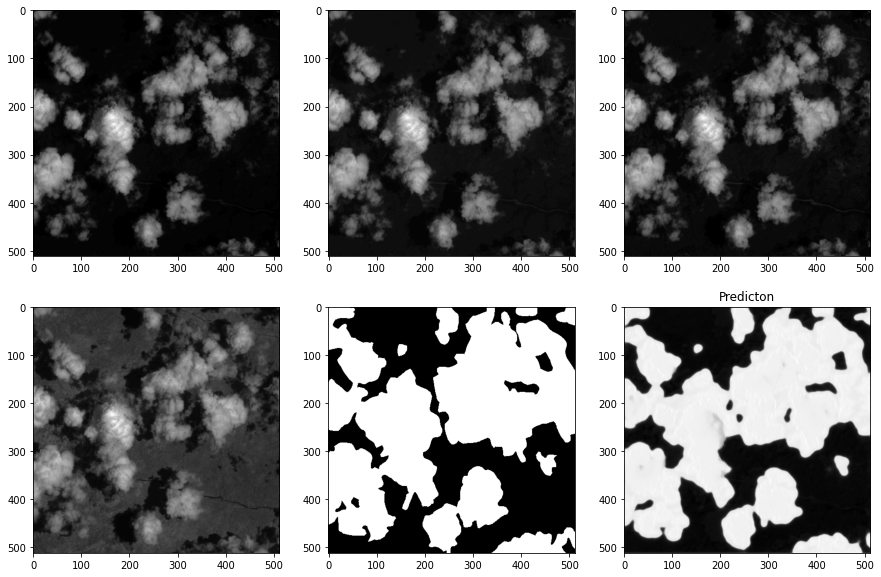

In [34]:
random_predict()